## Modeling

**Models**
- Several machine learning (ML) models are created and compared. The list includes logistic regression, Random Forest, XGBoost, LightGBM, Isolation Forest, Local Outlier Factor (LOF), and Support Vector Machine (SVM)
- Supervised: Logistic regression, random forest, XGBoost, LightGBM, SVM
- Unsupervised: Isolation forest, LOF
- Note: SVM is slow to run if the dataset is large and it uses a non-linear kernel (such as the default kernel for SVC() which is the RBF kernel). In this dataset, it took over 2 hours to run SVM using the default (SVC(probability=True, random_state=42)) so I decided to change the kernel to ‘linear’. I also tried increasing max_iter to 1000 because setting the kernel to 'linear' was still too slow to run, but that resulted in "ConvergenceWarning". Therefore, I decided to try another way to speed up SVM and used SGDClassifier (with loss = 'hinge' for bindary classification). Covariates V1-V28 already had means of 0, and Log_Amount was scaled by RobustScalar making its mean 0 as well. The standard deviations vary somewhat, but they are between 0.33 and 1.96 so this should be sufficient to use this classifier

**Evaluation Steps**
- Plot ROC and Precision-Recall (PR) curves for all models, and use ROC AUC, PR AUC, and curve shape to identify and drop clear underperformers
- Perform threshold tuning on the smaller list of models based on precision, recall, and F1 score at various thresholds to choose the best fit. The best model should have a high recall value with reasonable precision for fraud detection
- Compare models based on their "best" tresholds. Examine confusion matrices, precision, recall, F1 score, and accuracy
- Note: In this initial round of testing, I am focusing on identifying and dropping clear low performers and narrowing down the list to 2-3 models. Therefore, I will just use the default setting for model paramers unless it is to make the model run without errors or to set a random seed

**Next Step - Hyperparameter Tuning**
- Tune parameteres of 2-3 best performing models chosen in this step
- Compare the tuned models and choose the final model

In [1]:
#Import Python libraries
import pandas as pd
import numpy as np
import joblib
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.metrics import roc_curve, precision_recall_curve, auc, f1_score, accuracy_score, precision_score, recall_score


In [2]:
#Read in train/test data from preprocessing
X_test = joblib.load('../data/X_test.pkl')
y_test = joblib.load('../data/y_test.pkl')
X_train = joblib.load('../data/X_res.pkl')
y_train = joblib.load('../data/y_res.pkl')

In [3]:
#Create base SGDClassifier
base_sgd = SGDClassifier(loss='hinge', max_iter=1000, random_state=42)

#Wrap with calibration (to get probabilities later)
calibrated_sgd = CalibratedClassifierCV(base_sgd, method='sigmoid', cv=5)  #Using default parameter values

In [4]:
#Create a dictionary to hold models
models = {
    'Logistic Regression': LogisticRegression(max_iter = 1000, verbose = 1, C= 1),
    'Random Forest': RandomForestClassifier(n_estimators = 100, random_state = 42),
    'XGBoost': XGBClassifier(eval_metric = 'logloss', random_state = 42),
    'LightGBM': LGBMClassifier(random_state = 42),
    'Isolation Forest': IsolationForest(contamination = 'auto', random_state = 42),
    'Local Outlier Factor': LocalOutlierFactor(novelty = True, contamination = 'auto'),
    'Linear SVM (SGD)': calibrated_sgd
}
#LOF has novelty = True because I want to predict on test (unseen) data
#Setting use_label_encoder = False per recommendation from XGBoost website (using newer version of the library)
#XGBoost uses logloss as the evaluation metric because this is for binary classification

In [5]:
#Create an empty dictionary to hold the results
results = {}

#Run the models
for name, model in models.items():
    print(f"\nTraining and evaluating: {name}")
    start_time = time.time()
    
    #Run unsupervised models first (only requires X_train)
    if name in ['Isolation Forest', 'Local Outlier Factor']:
        model.fit(X_train)
        #y_pred = model.predict(X_test)
        y_score = -model.decision_function(X_test) 
        #Adding '-' because negative = more likely to be an anomaly, positive = more likely to be non-anomaly
        #Because LOF and IF gives 1 for non-anomaly and -1 for outliers, convert that to 0, 1 to match Class
        #y_pred = np.where(y_pred == 1, 0, 1)
        #Print out the evaluation metrics
        #print(confusion_matrix(y_test,y_pred))
        #print('\n')
        #print(classification_report(y_test, y_pred))
        #print('\n')
        #print(f"ROC AUC: {roc_auc_score(y_test, y_score): .4f}")

    else: #Supervised models need both X and y to train
        model.fit(X_train, y_train)
        #y_pred = model.predict(X_test)
        y_score = model.predict_proba(X_test)[:,1] #use the probabilities for the fraud (Class = 1) class
        #print(confusion_matrix(y_test, y_pred))
        #print('\n')
        #print(classification_report(y_test, y_pred))
        #print('\n')
        #print(f"ROC AUC: {(roc_auc_score(y_test, y_score)): .4f}")

    end_time = time.time()
    #Calculate how long it took to run each model
    elapsed_time = end_time - start_time
    print(f"{name} Time: {elapsed_time: .2f} seconds")
    
    #Save results in the dictionary results
    results[name] = {
        'model': model,
        #'y_pred': y_pred,
        'runtime': elapsed_time,
        'y_score': y_score,
        'roc_auc': roc_auc_score(y_test, y_score)
    }



Training and evaluating: Logistic Regression
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  1.75100D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     32     34      1     0     0   4.742D-05   1.246D-01
  F =  0.12459408301308363     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Logistic Regression Time:  0.72 seconds

Training and evaluating: Random Forest
Random Forest Time:  202.55 seconds

Training and evaluating: XGBoost
XGBoost Time:  1.09 seconds

Training and evaluating: LightGBM
[LightGBM] [Info] Number of positive: 227451, number of negative: 227451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014713 seconds.
You can set `force_col_wise=true`

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Local Outlier Factor Time:  128.34 seconds

Training and evaluating: Linear SVM (SGD)
Linear SVM (SGD) Time:  3.10 seconds


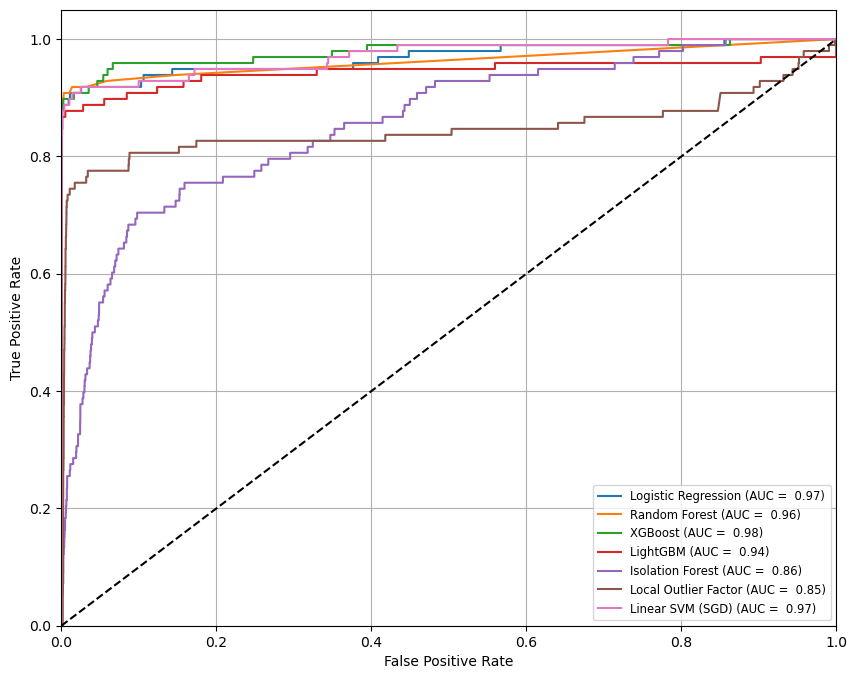

In [6]:
#Plot ROC curves for all models
plt.figure(figsize = (10,8))

for name, result in results.items():
    model = result['model']
    y_scores = result['y_score']

    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc: .2f})") 

plt.plot([0,1],[0,1], 'k--') #add a diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
#Add labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.savefig("roc_curve_all_models.png", dpi = 300)
plt.show()


- Looking at ROC curves, isolation forest and LOF do not perform as well as the supervised models, although all models do perform relatively well and have AUC greater than or equal to 0.85
- Next, look at Precision-Recall

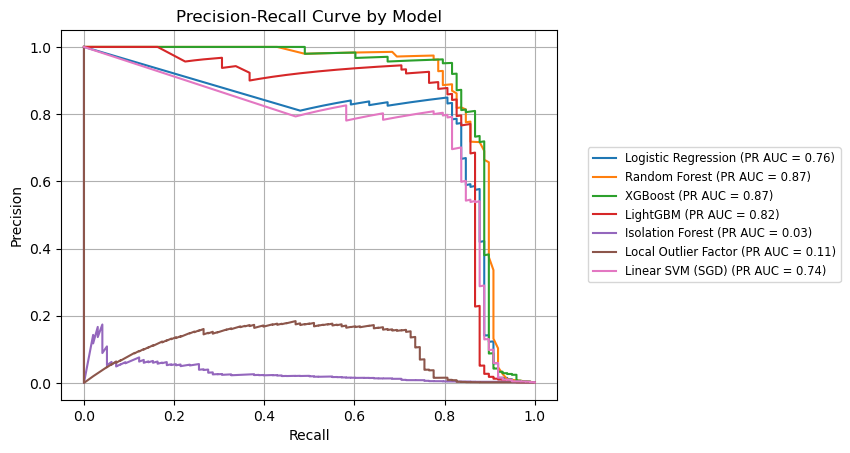

In [12]:
#Plot Precision-Recall (PR) Curve
for name, result in results.items():
    y_scores = result['y_score']
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"{name} (PR AUC = {pr_auc:.2f})")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve by Model')
plt.legend(loc = 'center left', bbox_to_anchor=(1.05,0.5), fontsize = 'small')
plt.grid(True)
plt.savefig("PR_curve_all_models.png", dpi = 300, bbox_inches = 'tight')
plt.show()

- Based on the Precision-Recall curve, isolation forest and LOF (the two lines on the bottom) do not perform well regardless of the threshold. No matter the threshold, there are no points that have both reasonable recall and precision values, especially compared to the other models. AUC values are also low
- Note that the previous ROC curve plot also showed that the isolation frest and LOF were the worst performing models
- Since the goal of the model is real-time fraud detection, isolation forest and LOF are not ideal compared to the other supervised methods because of how they identify anomalies. They require that the new data points follow exactly the pattern of the training data
- Based on these observations, and since there are more favorable models (even with default parameters) for the purpose of this project, I will drop isolation forest and LOF from further consideration

- Now, the remaining models for comparison are logistic regression, Random Forest, XGBoost, LightGBM, and Linear SVM (SGD). To narrow them down further, let's compare them, using optimal thresholds for each model

**Threshold tuning for Logistic Regression, Random Forest, XGBoost, LightGBM, and Linear SVM (SGD)**

For each model, I want to find the best threshold that would yield a high recall value, say, >= 0.85, and an acceptable precision value (can be lower in this case, let's say 0.2). I will also check to see if the threshold yields the highest F1 score, which balances recall and precision by taking a harmonic mean of recall and precision.

Note: Recall is equal to TP/(TP+FN), meaning that this value indicates the model's ability to identify fraud cases correctly among all fraud cases. By setting the minimum to 0.85, the model should detect at least 85% of fraud cases. Precision is equal to TP/(TP+FP), which shows the ratio of fraud cases identified correctly among all cases identified as fraud. For our real-time fraud detection purposes, I assume that a lower precision is acceptable (i.e., the model would flag non-fraud cases as fraud "just in case"), given that there is a simple way for the credit card users to approve the flagged charges if they were not fraudulent charges in reality.

Below, identify the threshold where each model has the largest F1 score among rows where recall is greater than or equal to recall threshold of 0.85.


Evaluating threshold for: Logistic Regression
Best threshold with recall >= 0.85: 
threshold    0.994408
precision    0.591549
recall       0.857143
f1_score     0.700000
Name: 56136, dtype: float64


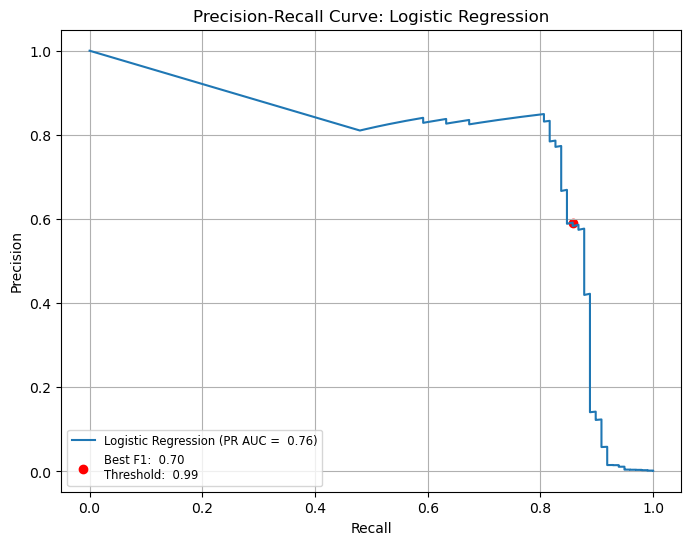


Evaluating threshold for: Random Forest
Best threshold with recall >= 0.85: 
threshold    0.340000
precision    0.777778
recall       0.857143
f1_score     0.815533
Name: 33, dtype: float64


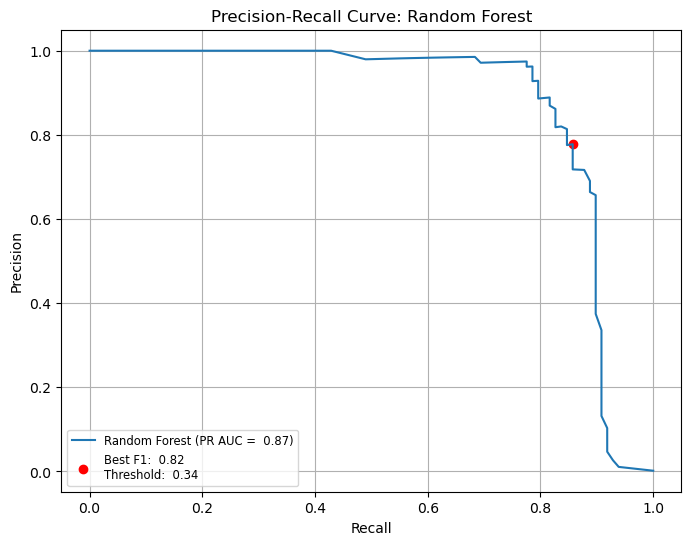


Evaluating threshold for: XGBoost
Best threshold with recall >= 0.85: 
threshold    0.697684
precision    0.809524
recall       0.867347
f1_score     0.837438
Name: 54967, dtype: float64


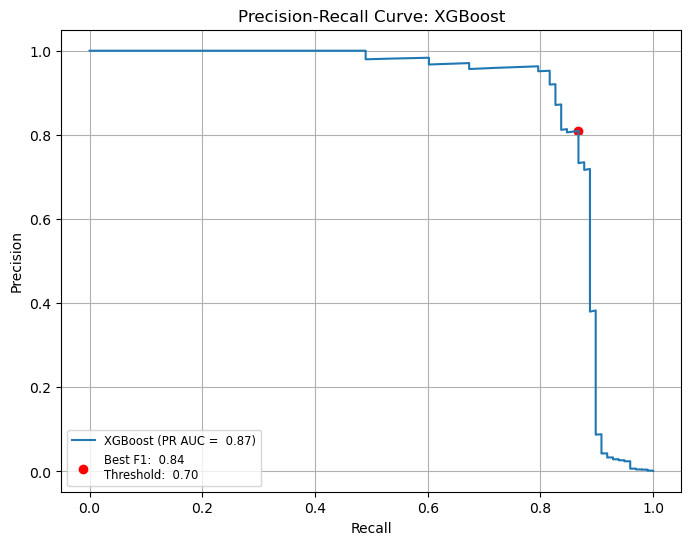


Evaluating threshold for: LightGBM
Best threshold with recall >= 0.85: 
threshold    0.904467
precision    0.770642
recall       0.857143
f1_score     0.811594
Name: 54272, dtype: float64


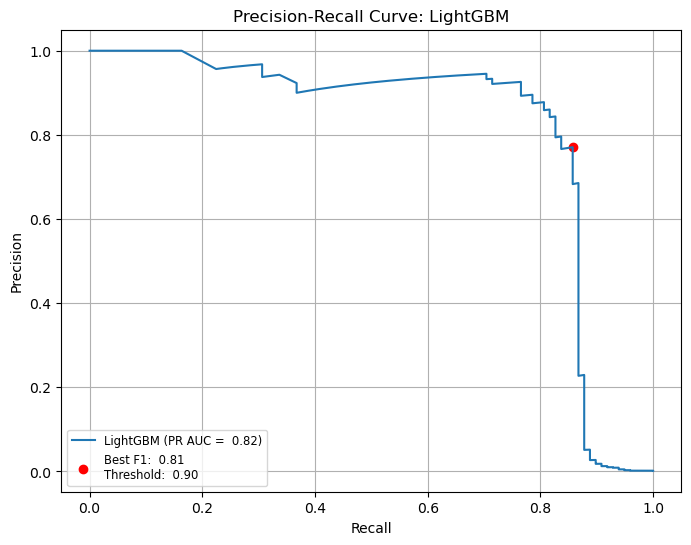


Evaluating threshold for: Isolation Forest
Best threshold with recall >= 0.85: 
threshold   -0.109624
precision    0.004033
recall       0.857143
f1_score     0.008028
Name: 34683, dtype: float64


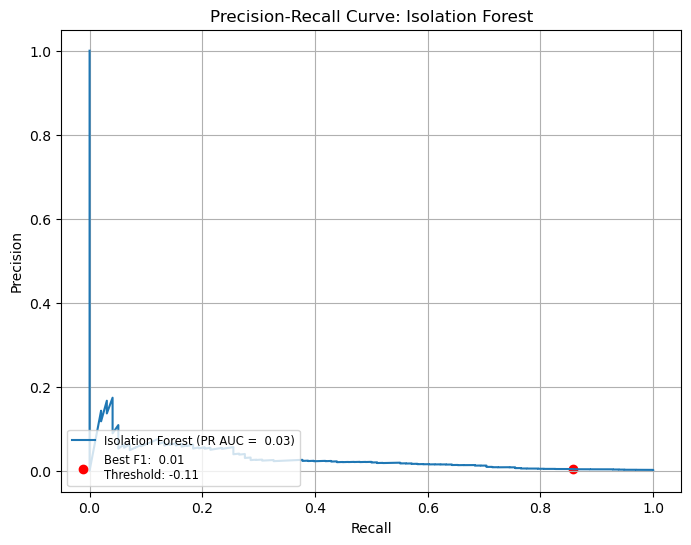


Evaluating threshold for: Local Outlier Factor
Best threshold with recall >= 0.85: 
threshold   -0.454225
precision    0.002300
recall       0.857143
f1_score     0.004588
Name: 19787, dtype: float64


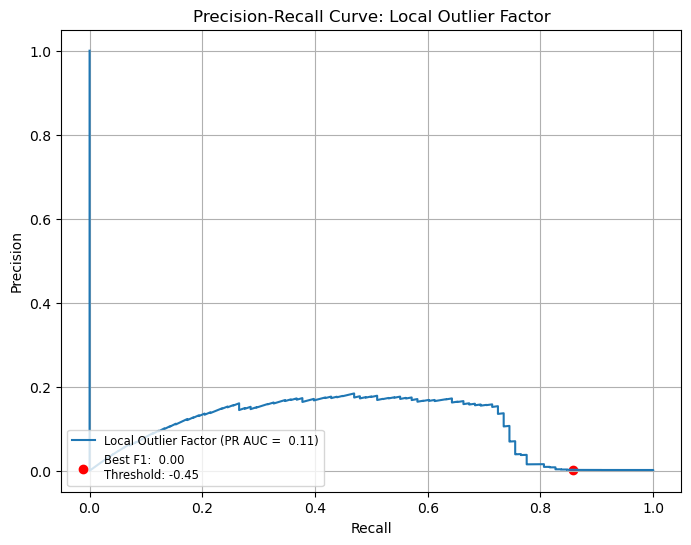


Evaluating threshold for: Linear SVM (SGD)
Best threshold with recall >= 0.85: 
threshold    0.991730
precision    0.540881
recall       0.877551
f1_score     0.669260
Name: 56119, dtype: float64


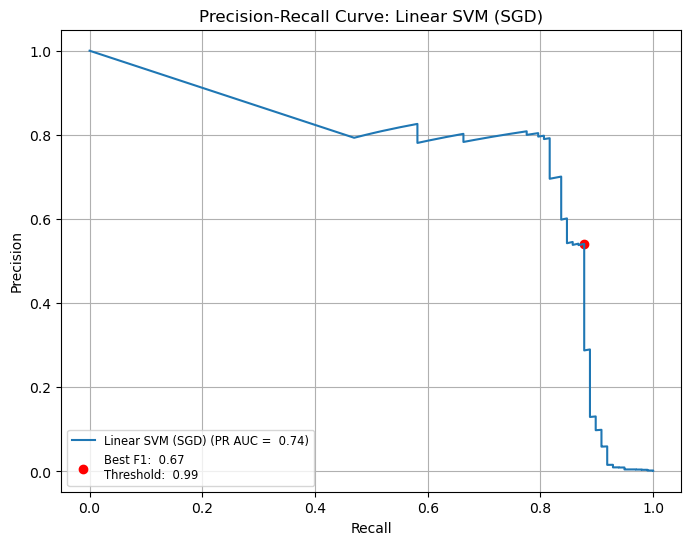

In [8]:
#Set recall threshold
RECALL_THRESHOLD = 0.85
best_thresholds = {}

for name, result in results.items():
    print(f"\nEvaluating threshold for: {name}")

    y_scores = result['y_score']

    #Get precision, recall, and threshold
    precision, recall, threshold = precision_recall_curve(y_test, y_scores)
    thresholds = np.append(threshold, np.nan) #Adding one more value because precision and recall are longer by 1 value than threshold

    #Calculate F1 score from precision and recall
    f1_scores = 2 * (precision * recall)/(precision + recall + 1e-6)
    #Adding negligible non-zero value to avoid a "divded by zero" error

    #Create a DataFrame
    pr_df = pd.DataFrame({
        'threshold': thresholds,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_scores
    })

    #Filter pr_df to those that meet recall >= RECALL_THRESHOLD
    pr_filtered = pr_df[pr_df['recall'] >= RECALL_THRESHOLD]

    if not pr_filtered.empty: #If pr_filtered has at least one row
        best_row = pr_filtered.sort_values('f1_score', ascending = False).iloc[0]
        best_thresholds[name] = best_row['threshold']
        print(f"Best threshold with recall >= {RECALL_THRESHOLD}: ")
        print(best_row)
    else:
        print(f"No threshold meets recall >= {RECALL_THRESHOLD}")
        #Create a dummy best_row so I can still see PR curve when there are no thresholds that meet the criteria
        best_row = pd.Series({
            'threshold': 0.0,
            'precision': 0.0,
            'recall': 0.0,
            'f1_score': 0.0
        })

    #Plot PR curve with best threshold mark based on F1 value
    plt.figure(figsize = (8,6))
    plt.plot(recall, precision, label = f"{name} (PR AUC = {auc(recall, precision): .2f})")
    plt.scatter(best_row['recall'], best_row['precision'], color = 'red', label = f"Best F1: {best_row['f1_score']: .2f}\nThreshold: {best_row['threshold']: .2f}")

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f"Precision-Recall Curve: {name}")
    plt.legend(loc = 'lower left', fontsize = 'small')
    plt.grid(True)
    plt.show()


Based on the above, the best threshold for each model is as follows.

- Logistic Regression: 0.994 (yields recall = 0.857, precision = 0.592, f1_score = 0.700)
- Random Froest: 0.340 (yields recall = 0.857, precision = 0.778, f1_score = 0.816)
- XGBoost: 0.698 (yields recall = 0.867, precision = 0.810, f1_score = 0.837)
- LightGBM: 0.904 (yields recall = 0.857, precision = 0.771, f1_score = 0.812)
- Linear SVM (SGD): 0.992 (yields recall = 0.878, precision = 0.541, f1_score = 0.669)

Based on these statistics, Random Forest, XGBoost, and LightGBM are the top 3 performing models with corresponding "best" thresholds

In [9]:
#Compare the model results using their corresponding best thresholds
metrics_list = []

for name, result in results.items():
    y_scores = result['y_score']
    threshold = best_thresholds.get(name, 0.5) #set it to 0.5 if not found

    y_pred = (y_scores >= threshold).astype(int)
    precision = precision_score(y_test, y_pred, zero_division = 0)
    recall = recall_score(y_test, y_pred, zero_division = 0)
    f1 = f1_score(y_test, y_pred, zero_division = 0)
    accuracy = accuracy_score(y_test, y_pred)

    metrics_list.append({
        'Model': name,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Accuracy':accuracy
    })
    
    print(f"\n{name} - Evaluation at threshold {threshold: .2f}")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    print(classification_report(y_test, y_pred, digits = 4))


Logistic Regression - Evaluation at threshold  0.99
[[56806    58]
 [   14    84]]
              precision    recall  f1-score   support

           0     0.9998    0.9990    0.9994     56864
           1     0.5915    0.8571    0.7000        98

    accuracy                         0.9987     56962
   macro avg     0.7957    0.9281    0.8497     56962
weighted avg     0.9991    0.9987    0.9989     56962


Random Forest - Evaluation at threshold  0.34
[[56840    24]
 [   14    84]]
              precision    recall  f1-score   support

           0     0.9998    0.9996    0.9997     56864
           1     0.7778    0.8571    0.8155        98

    accuracy                         0.9993     56962
   macro avg     0.8888    0.9284    0.9076     56962
weighted avg     0.9994    0.9993    0.9993     56962


XGBoost - Evaluation at threshold  0.70
[[56844    20]
 [   13    85]]
              precision    recall  f1-score   support

           0     0.9998    0.9996    0.9997     56864
   

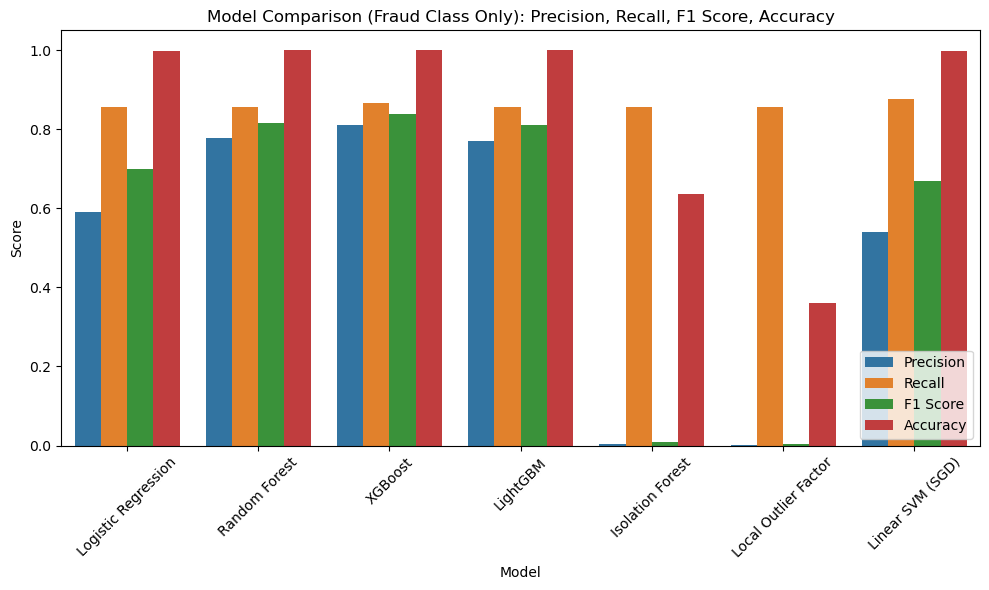

In [10]:
#Plot metrics
metrics_df = pd.DataFrame(metrics_list)
#Transpose to long format for plotting
metrics_long = metrics_df.melt(id_vars = 'Model', var_name = 'Metric', value_name = 'Score')

#Plot metrics in grouped bar chart
plt.figure(figsize = (10,6))
sns.barplot(x = 'Model', y = 'Score', hue = 'Metric', data = metrics_long)
plt.title('Model Comparison (Fraud Class Only): Precision, Recall, F1 Score, Accuracy')
plt.ylim(0,1.05)
plt.xticks(rotation = 45)
plt.legend(loc = 'lower right')
plt.tight_layout()
plt.savefig("evaluation_metrics_all_models.png", dpi = 300)
plt.show()


**Results**
- Among all models, isolation forest and local outlier factor are the worst performers with lowest values for all metrics besides recall. This is consistent with what was observed from the previous plots/output
- Among the rest, XGBoost has the highest F1 score for fraud class, with Random Forest and LightGBM being the second and third best. Bar graph also indicates that XGBoost, Random Forest, and LightGBM are the top 3 performers
- Looking at the confusion matrices, TP and FN values are similar across all models. When looking at TN and FP counts, however, XGBoost, Random Forest, and LightGBM did the best
- When fitting and scoring the models, XGBoost took 1.09 seconds, Random Forest took 202.65 seconds, and LightGBM took 1.24 seconds. While Random Forest was much slower than the other two, this will likely not be a problem once the model is trained since in application of the model, training step will not be repeated in real-time

**Conclusion**
- XGBoost, Random Forest, and LightGBM are the most suitable models and should proceed to hyperparameter tuning phase

**Next Step**
- Apply hyperparameter tuning to XGBoost, Random Forest, and LightGBM to determine the best parameters for each model
- Compare the tuned models and select the final model
- Build a pipeline that includes preprocessing, application of the final model, and prediction
- Provide a pipeline application example

In [11]:
#Save results
joblib.dump(results, "../data/results.pkl")
#joblib.dump(best_thresholds, "../data/best_thresholds.pkl")

['../data/results.pkl']